In [1]:
import os
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt

In [ ]:
def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    requested_mbps, duration, packet_length, cpu_limit, _, _ = folder_name.split('_')
    
    power_consumptions = []
    cpu_usages = []
    
    # Process iperf server log
    server_file = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_file:
        server_file = server_file[0]
        df_server = pd.read_csv(server_file)
        
        # Calculate the average Mbps effectively received at server using 'Transfer' column
        # Convert each interval's transfer (in bytes) to Mbps and then calculate the average
        df_server['Mbps'] = df_server['Bitrate'] / 1e6  # Convert each interval's Transfer from bps to Mbps
        avg_mbps_received = df_server['Mbps'].mean()  # Average Mbps over all intervals
        
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
        
        # Collect timestamps and values for CU container
        timestamps = []
        values = []
        for pod_data in power_data.values():
            for entry in pod_data:
                timestamps.append(entry['timestamp'])
                values.append(entry['value'])
        
        # Convert timestamps to a relative time from start
        start_time = min(timestamps)
        end_time = max(timestamps)
        power_consumptions = [
            value for ts, value in zip(timestamps, values) 
            if (ts - start_time > 20) and (end_time - ts > 20)  # Exclude first and last 20 seconds
        ]
        
        # Calculate average power consumption for CU
        avg_power_consumption = sum(power_consumptions) / len(power_consumptions) if power_consumptions else 0
    else:
        avg_power_consumption = 0  # Default if no data found
    
    # Process CPU usage data
    cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    if os.path.exists(cpu_file):
        with open(cpu_file, 'r') as f:
            cpu_data = json.load(f)
        
        # Collect CPU values for CU container
        for pod_data in cpu_data.values():
            for entry in pod_data:
                cpu_usages.append(entry['value'])
        
        # Calculate average CPU usage for CU
        avg_cpu_usage = sum(cpu_usages) / len(cpu_usages) if cpu_usages else 0
    else:
        avg_cpu_usage = 0  # Default if no data found
    
    # Return row data
    return {
        "cpu limit at cu": cpu_limit,
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "avg Mbps effectively received at server": avg_mbps_received,
        "avg cu power consumption [W]": avg_power_consumption,
        "avg cu cpu usage [%]": avg_cpu_usage,
    }



In [3]:
def main(base_folder_path):
    data = []
    # Iterate over each sub-folder in the base folder
    for folder in os.listdir(base_folder_path):
        folder_path = os.path.join(base_folder_path, folder)
        if os.path.isdir(folder_path):
            row = process_folder(folder_path)
            data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Path to the base folder containing all experiment folders
base_folder_path = "/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/exp4"
df = main(base_folder_path)

# Save DataFrame to CSV
# df.to_csv("summary_metrics.csv", index=False)
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['Mbps requested'] == 40]
df_show['cpu limit at cu'] = df_show['cpu limit at cu'].str.replace('mi', '').astype(int)
df_show = df_show.sort_values(by='cpu limit at cu')
df_show


,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu power consumption [W],avg cu cpu usage [%]
56,25,40,700,11.247170,0.064272,100.060616
53,50,40,700,19.697684,0.072320,85.145240
60,75,40,700,28.681968,0.074802,99.992927
15,100,40,700,36.553551,0.080027,99.759947
22,125,40,700,41.419887,0.086846,95.205592
6,150,40,700,41.891134,0.082935,80.900376
5,175,40,700,41.948159,0.086602,69.948945
26,200,40,700,41.941019,0.085339,61.004363
3,225,40,700,41.942702,0.084429,43.865960
12,250,40,700,41.916675,0.087273,39.972769


In [4]:
# # Select rows to compare
# row_3 = df[df["cpu limit at cu"] == 200].iloc[0]
# print(row_3)
# row_5 = df[df["cpu limit at cu"] == 1000].iloc[0]
# (row_5["avg cu power consumption [W]"] - row_3["avg cu power consumption [W]"]) / row_5["avg cu power consumption [W]"] * 100

# Power Consumption [W] over Requested Throughput [Mbps]

In [5]:
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 50]
df_show = df_show.sort_values(by='Mbps requested')
df_show

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu power consumption [W],avg cu cpu usage [%]
23,50mi,20,700,16.127866,0.066484,99.962360
24,50mi,30,700,17.012769,0.071131,100.001598
53,50mi,40,700,19.697684,0.072320,85.145240
25,50mi,50,700,19.718493,0.069014,99.989831
48,50mi,60,700,20.045405,0.074795,100.134463
49,50mi,70,700,20.708380,0.075032,100.004430


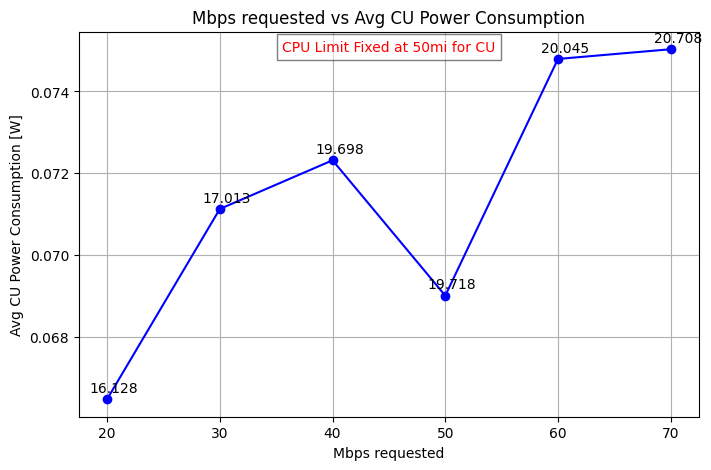

In [6]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(df_show["Mbps requested"],df_show["avg cu power consumption [W]"], marker='o', linestyle='-', color='b')

# Add labels and title
plt.ylabel("Avg CU Power Consumption [W]")
plt.xlabel("Mbps requested")
plt.title("Mbps requested vs Avg CU Power Consumption")
plt.grid(True)

# Annotate points (corrected coordinates)
for i in range(len(df_show)):
    plt.annotate(f"{round(df_show['avg Mbps effectively received at server'].iloc[i],3)}",
                 (df_show["Mbps requested"].iloc[i], df_show["avg cu power consumption [W]"].iloc[i]),
                 textcoords="offset points", xytext=(5, 5), ha='center')
# Add a label to indicate the fixed CPU limit
cpu_limit_fixed = df_show["cpu limit at cu"].iloc[0]  # Example value of the fixed CPU limit
plt.text(
    0.5, 0.95,  # X and Y positions in axes coordinates (relative to the plot area)
    f"CPU Limit Fixed at {cpu_limit_fixed} for CU", 
    transform=plt.gca().transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
    fontsize=10, color='red', ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
# Show the plot
plt.show()


In [7]:
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 200]
df_show = df_show.sort_values(by='Mbps requested')
df_show

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu power consumption [W],avg cu cpu usage [%]
43,200mi,20,700,20.972421,0.069969,40.731541
58,200mi,30,700,31.445486,0.087128,45.883441
26,200mi,40,700,41.941019,0.085339,61.004363
33,200mi,50,700,52.419919,0.096226,65.966940
42,200mi,60,700,62.685780,0.111251,88.997206
2,200mi,70,700,71.801441,0.111829,85.060223


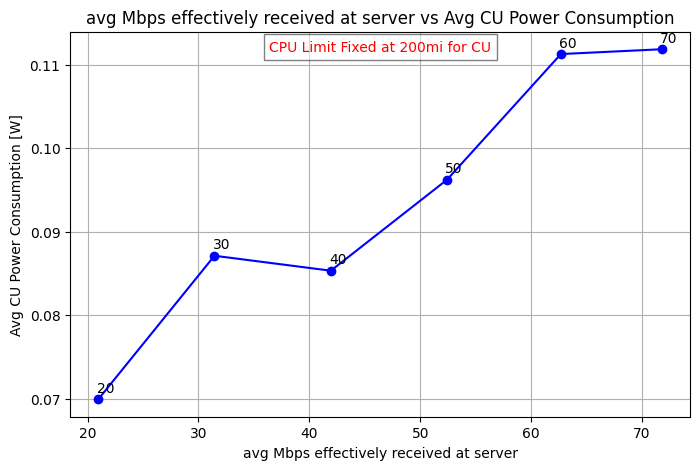

In [8]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(df_show["avg Mbps effectively received at server"],df_show["avg cu power consumption [W]"], marker='o', linestyle='-', color='b')

# Add labels and title
plt.ylabel("Avg CU Power Consumption [W]")
plt.xlabel("avg Mbps effectively received at server")
plt.title("avg Mbps effectively received at server vs Avg CU Power Consumption")
plt.grid(True)

# Annotate points (corrected coordinates)
for i in range(len(df_show)):
    plt.annotate(f"{df_show['Mbps requested'].iloc[i]}",
                 (df_show["avg Mbps effectively received at server"].iloc[i], df_show["avg cu power consumption [W]"].iloc[i]),
                 textcoords="offset points", xytext=(5, 5), ha='center')
#Add a label to indicate the fixed CPU limit
cpu_limit_fixed = df_show["cpu limit at cu"].iloc[0]  # Example value of the fixed CPU limit
plt.text(
    0.5, 0.95,  # X and Y positions in axes coordinates (relative to the plot area)
    f"CPU Limit Fixed at {cpu_limit_fixed} for CU", 
    transform=plt.gca().transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
    fontsize=10, color='red', ha='center', bbox=dict(facecolor='white', alpha=0.5)
)

# Show the plot
plt.show()


# Power Consumption [W] over Received Throughput [Mbps]

In [9]:
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['Mbps requested'] == 50]
df_show['cpu limit at cu'] = df_show['cpu limit at cu'].str.replace('mi', '').astype(int)
# df_show = df_show[df_show['cpu limit at cu'] != 225]
# df_show = df_show[df_show['cpu limit at cu'] != 100]

df_show = df_show.sort_values(by='cpu limit at cu')
df_show

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu power consumption [W],avg cu cpu usage [%]
39,25,50,700,11.204438,0.065894,99.871123
25,50,50,700,19.718493,0.069014,99.989831
9,75,50,700,29.178860,0.077269,100.023547
8,100,50,700,36.497076,0.086140,99.953338
20,125,50,700,45.745835,0.085220,99.715194
64,150,50,700,51.148441,0.099250,84.563331
37,175,50,700,52.419979,0.097104,85.241195
33,200,50,700,52.419919,0.096226,65.966940
17,225,50,700,52.414559,0.097410,58.493005
19,500,50,700,NaN,0.007280,22.496453


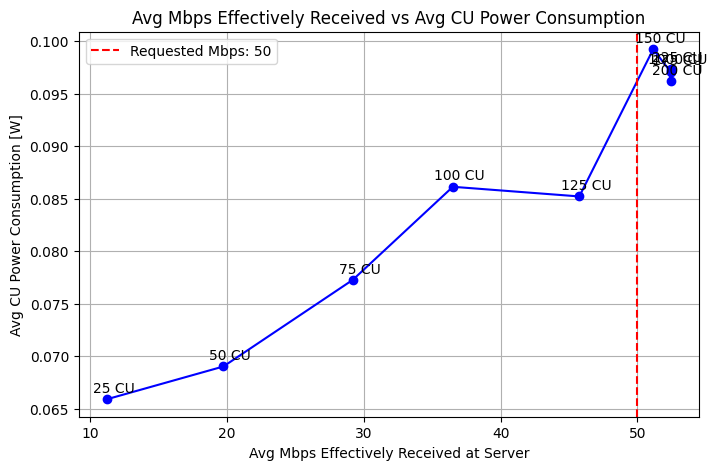

In [10]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(df_show["avg Mbps effectively received at server"], df_show["avg cu power consumption [W]"], marker='o', linestyle='-', color='b')

# Add labels and title
plt.ylabel("Avg CU Power Consumption [W]")
plt.xlabel("Avg Mbps Effectively Received at Server")
plt.title("Avg Mbps Effectively Received vs Avg CU Power Consumption")
plt.grid(True)

# Annotate points (corrected coordinates)
for i in range(len(df_show)):
    plt.annotate(f"{df_show['cpu limit at cu'].iloc[i]} CU",
                 (df_show["avg Mbps effectively received at server"].iloc[i], df_show["avg cu power consumption [W]"].iloc[i]),
                 textcoords="offset points", xytext=(5, 5), ha='center')

# Add a vertical line at the requested Mbps
requested_mbps_fixed = df_show["Mbps requested"].iloc[0]  # Get the fixed requested Mbps value
plt.axvline(
    x=requested_mbps_fixed,  # Vertical line at the requested Mbps value
    color='red', linestyle='--', linewidth=1.5, label=f"Requested Mbps: {requested_mbps_fixed}"
)

# Add a legend
plt.legend()

# Show the plot
plt.show()


# CPU over Performances

In [11]:
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['Mbps requested'] == 50]
df_show['cpu limit at cu'] = df_show['cpu limit at cu'].str.replace('mi', '').astype(int)
df_show = df_show.sort_values(by='cpu limit at cu')
df_show

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu power consumption [W],avg cu cpu usage [%]
39,25,50,700,11.204438,0.065894,99.871123
25,50,50,700,19.718493,0.069014,99.989831
9,75,50,700,29.178860,0.077269,100.023547
8,100,50,700,36.497076,0.086140,99.953338
20,125,50,700,45.745835,0.085220,99.715194
64,150,50,700,51.148441,0.099250,84.563331
37,175,50,700,52.419979,0.097104,85.241195
33,200,50,700,52.419919,0.096226,65.966940
17,225,50,700,52.414559,0.097410,58.493005
19,500,50,700,NaN,0.007280,22.496453


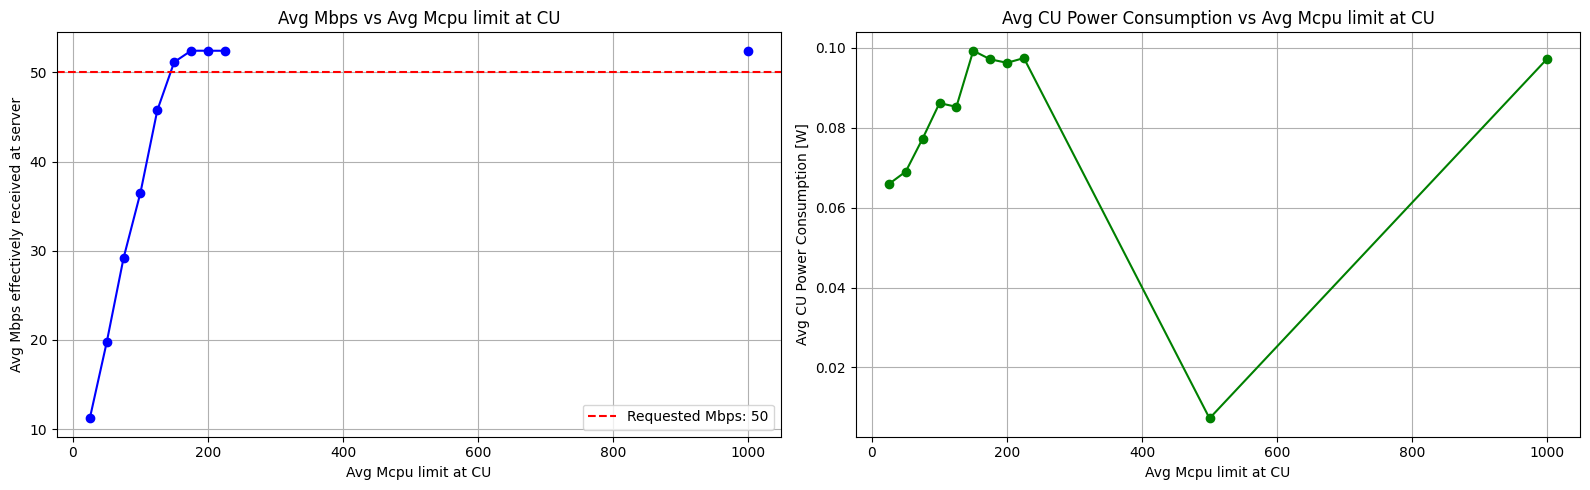

In [12]:
# Create subplots: one row, two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # Two subplots in one row

# Plot 1: Avg Mbps effectively received at server vs Avg Mcpu limit at CU
axes[0].plot(df_show["cpu limit at cu"], df_show["avg Mbps effectively received at server"], 
             marker='o', linestyle='-', color='b')
axes[0].set_ylabel("Avg Mbps effectively received at server")
axes[0].set_xlabel("Avg Mcpu limit at CU")
axes[0].set_title("Avg Mbps vs Avg Mcpu limit at CU")
axes[0].grid(True)

# Add a horizontal line at the requested Mbps in Plot 1
requested_mbps_fixed = df_show["Mbps requested"].iloc[0]  # Get the fixed requested Mbps value
axes[0].axhline(
    y=requested_mbps_fixed,  # Horizontal line at the requested Mbps value
    color='red', linestyle='--', linewidth=1.5, label=f"Requested Mbps: {requested_mbps_fixed}"
)
axes[0].legend()

# Plot 2: Avg CU Power Consumption [W] vs Avg Mcpu limit at CU
axes[1].plot(df_show["cpu limit at cu"], df_show["avg cu power consumption [W]"], 
             marker='o', linestyle='-', color='g')
axes[1].set_ylabel("Avg CU Power Consumption [W]")
axes[1].set_xlabel("Avg Mcpu limit at CU")
axes[1].set_title("Avg CU Power Consumption vs Avg Mcpu limit at CU")
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


# Debug

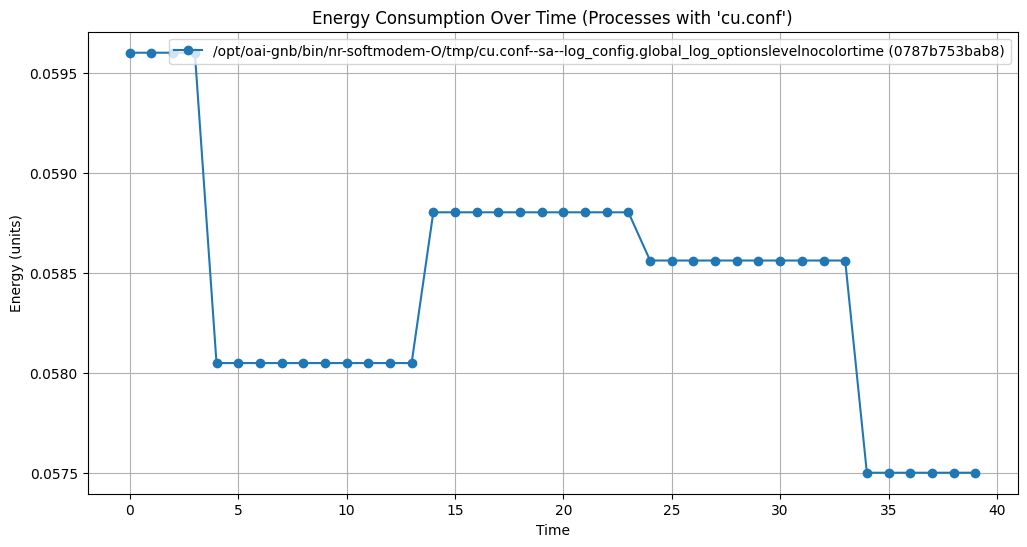

In [20]:
# Path to the JSON file
file_path = '/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/exp4/70_100_700_100mi_at_cu/metrics_energy.json'

# Load JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Filter for entries where cmdline contains "cu.conf"
filtered_data = {}
for process_id, metrics in data.items():
    if any("cu.conf" in metric['cmdline'] for metric in metrics):
        filtered_data[process_id] = metrics

# Process power consumption data
# Collect timestamps and values for CU container
timestamps = []
values = []
for pod_data in filtered_data.values():
    for entry in pod_data:
        timestamps.append(entry['timestamp'])
        values.append(entry['value'])

# Convert timestamps to a relative time from start
start_time = min(timestamps)
end_time = max(timestamps)
filtered_values = [
    value for ts, value in zip(timestamps, values) 
    if (ts - start_time > 30) and (end_time - ts > 30)  # Exclude first and last 20 seconds
]


# Plot the filtered data
plt.figure(figsize=(12, 6))

for process_id, metrics in filtered_data.items():
    timestamps = range(0,len(filtered_values))
    values = filtered_values
    cmdline = next(metric['cmdline'] for metric in metrics if "cu.conf" in metric['cmdline'])
    plt.plot(timestamps, values, marker='o', label=f"{cmdline} ({process_id})")

# Add labels, title, legend, and grid
plt.xlabel("Time")
plt.ylabel("Energy (units)")
plt.title("Energy Consumption Over Time (Processes with 'cu.conf')")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
